<a href="https://colab.research.google.com/github/arakoma/pytorch_practice/blob/master/writing_custum_datasets_dataloaders_and_transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dataのロード,preprocess,augmentについてやっていく！

In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 画像の読み込みとかはopencvでやる(tutorialはio)
import cv2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

google drive のマウント

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive
!mkdir data
# data フォルダに、ダウンロードしたfacesデータ入れとく
# （/content/drive/My Drive/data/faces にする）

/content/drive/My Drive
mkdir: cannot create directory ‘data’: File exists


csvファイルにまとまってるので見てみる

In [5]:
landmarks_frame = pd.read_csv("data/faces/face_landmarks.csv")

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype("float").reshape(-1, 2)

print(img_name)
print(landmarks.shape)
print("first 5 landmarks :", landmarks[:5])

person-7.jpg
(68, 2)
first 5 landmarks : [[ 32.  65.]
 [ 33.  76.]
 [ 34.  86.]
 [ 34.  97.]
 [ 37. 107.]]


画像にlandmarkのせて見てみる

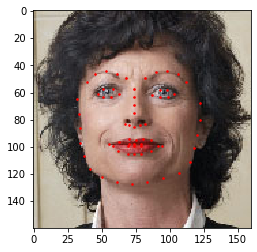

In [6]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)
    

image = cv2.imread("data/faces/{}".format(img_name))
image = image[:, :, (2, 1, 0)]

plt.figure()
show_landmarks(image, landmarks)
plt.show()

datasetをclassで扱っていく  
dataset class つくる  

torch.utils.data.Dataset classを継承して、`__len__`, `__getitem__`メソッドを上書きする

In [0]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        image = image[:, :, (2, 1, 0)]

        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype("float").reshape(-1, 2)

        sample = {"image": image, "landmarks": landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

最初の4枚だけ見てみる

0 image: (324, 215, 3) landmark: (68, 2)


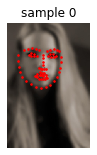

1 image: (500, 333, 3) landmark: (68, 2)


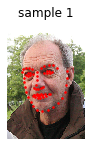

2 image: (250, 258, 3) landmark: (68, 2)


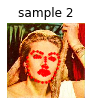

3 image: (434, 290, 3) landmark: (68, 2)


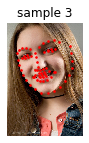

In [8]:
face_dataset = FaceLandmarksDataset(csv_file="data/faces/face_landmarks.csv",
                                    root_dir="data/faces/")

plt.figure()
for i in range(len(face_dataset)):
    sample = face_dataset.__getitem__(i)

    print(i, "image:", sample["image"].shape, "landmark:", sample["landmarks"].shape)

    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title("sample {}".format(i))
    ax.axis("off")
    show_landmarks(sample["image"], sample["landmarks"])

    if i == 3:
        plt.show()
        break

画像変換(transform)をclassで書く  
- rescale
- random crop
- to tensor (numpy -> tensor)  
を実装してみる  
  
classで書くと何がうれしいか  
→関数だと毎回パラメータわたすけど、classだとしなくていい  
(forで回すときとかに、オブジェクトにデータ渡すだけでよくなる)  
`__call__`
メソッドで引数のみ渡したときの処理を定義すると以下のように書ける  

```python
tsfm = Transform(params) # パラメータ指定してtransformオブジェクトつくる
transformed_sample = tsfm(sample) # オブジェクトにデータ渡して処理する
```

ここでよくわからなくてもコード読めばなんとなくわかるかも…



In [0]:
class Rescale(object):
    """
    画像の大きさを変える。
    output_size : int or tuple, 
                tupleならその大きさに変えて返す。
                intなら短辺をその長さ、アスペクト比を保つように変換。
    """

    def __init__(self, output_size):
        assert type(output_size) in (tuple, int)
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]

        h, w = image.shape[:2]
        size = self.output_size
        if type(size) is tuple:
            new_h, new_w = size
        elif type(size) is int:
            if h > w:
                new_h, new_w = size * h / w, size
            else:
                new_h, new_w = size, size * w / h
        
        new_h, new_w = int(new_h), int(new_w)
        new_image = transform.resize(image, (new_h, new_w))

        new_landmarks = landmarks * [new_w / w, new_h / h]

        return {"image": new_image, "landmarks": new_landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert type(output_size) in (int, tuple)
        if type(output_size) is int:
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

処理して見てみる

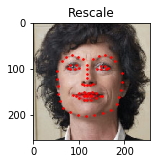

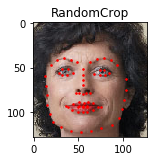

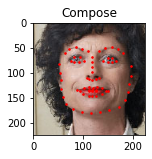

In [11]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

データセット全体で処理

In [0]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

これだと処理しただけで、batch,shuffle,に対応してないのでDataloaderつかう

In [0]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


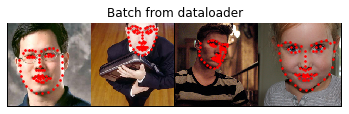

In [15]:
# 表示して見てみる
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break


今回は自作classをつくったけど、よくある処理はtorchvisionに実装されてるのが多いよ！！！  

以下例

In [0]:
"""
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)
"""